<a href="https://colab.research.google.com/github/lwalsh-fio/Big-Data-Projet-TP/blob/main/Projet_Big_Data_Maligne-Walsh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Projet BigData - Deep Learning MAPI3 2020-2021

# Importation des bibliothèques

In [1]:
import numpy as np
from keras.datasets import mnist
from google.colab import drive

In [2]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn import  metrics

In [3]:
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
import warnings 
warnings.filterwarnings("ignore")

# Importation des données

On travaille ici avec le dataset **Landscapes** qui contient 4000 images appartenant à 7 classes différentes listées ci-dessous. 

L'objectif de ce projet est d'entraîner plusieurs réseaux de neurones afin de classifier les paysages parmi ces 7 classes, le plus justement possible.

In [6]:
!wget https://github.com/ml5js/ml5-data-and-models/raw/master/datasets/images/landscapes/landscapes_small.zip
!mkdir landscapes
!unzip landscapes_small.zip -d landscapes
!rm -r landscapes/__MACOSX

--2022-03-09 17:23:35--  https://github.com/ml5js/ml5-data-and-models/raw/master/datasets/images/landscapes/landscapes_small.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ml5js/ml5-data-and-models/master/datasets/images/landscapes/landscapes_small.zip [following]
--2022-03-09 17:23:35--  https://raw.githubusercontent.com/ml5js/ml5-data-and-models/master/datasets/images/landscapes/landscapes_small.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81935123 (78M) [application/zip]
Saving to: ‘landscapes_small.zip’

landscapes_small.zi 100%[===================>]  78.14M   204MB/s    in 0

In [7]:
liste_classes=['city','field','forest','lake','mountain','ocean','road']

# Fonctions récupérées des TP

* **Fonction d'activation `softmax` : convertit un vecteur de valeurs en une distribution de probabilités. Le vecteur en sortie prend ses valeurs entre 0 et 1 et la somme de ces valeurs est égale à 1 :** 

In [8]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

* **Fonctions d'affichage `plot_learning_curves` et `plot_learning_curves2` : affiche les courbes d'apprentissages du modèle (Accuracy en fonction de Epoch et Loss en foncton de Epoch) pour le jeu d'entraînement et de test :**

In [9]:
def plot_learning_curves(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [10]:
def plot_learning_curves2(history):
  plt.plot(history.history['accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()

# Projet

## (1) Préparation du Dataset

On va utiliser des générateurs dans ce projet compte tenu de la taille du dataset. On utilise alors le générateur vu en TP.

In [11]:
input_dir = 'landscapes'

seed = 1
 
train_datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)


train_generator = train_datagen.flow_from_directory(input_dir,
        target_size=(256, 256),
        class_mode='categorical',
        batch_size=32,
        seed=seed, 
        subset='training')
valid_generator = train_datagen.flow_from_directory(input_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        seed=seed, 
        subset='validation')




Found 3026 images belonging to 7 classes.
Found 755 images belonging to 7 classes.


On peut alors

- Affichage de quelques images du dataset : 

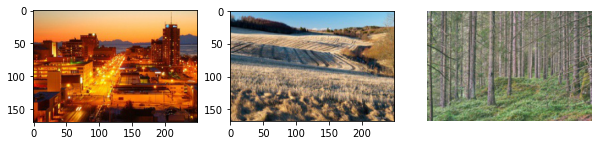

In [12]:

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
img = load_img(os.path.join(input_dir, 'city/3405806595_30426ee0dc.jpg'))
plt.imshow(img)
plt.subplot(1,3,2)
img = load_img(os.path.join(input_dir, 'field/6847664036_60c51ed2c9.jpg'))
plt.imshow(img)
plt.subplot(1,3,3)
img = load_img(os.path.join(input_dir, 'forest/35122786655_aa19f49666.jpg'))
plt.imshow(img)
plt.axis('off');

## (2) Entrainement du modèle

On prend un modèle assez classique, vu en TP, pour la classification d'image et on l'entraine sur 20 épochs.

In [13]:
num_classes = 7

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',activation='relu', input_shape=(256, 256,3)))
model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
history = model.fit(
      train_generator,
      steps_per_epoch=64, 
      epochs=20,
      validation_data=valid_generator,
      validation_steps=20)



Epoch 1/20
64/64 [==============================] - 29s 225ms/step - loss: 8.1474 - accuracy: 0.3274 - val_loss: 1.4779 - val_accuracy: 0.4125
Epoch 2/20
64/64 [==============================] - 13s 202ms/step - loss: 1.4456 - accuracy: 0.4872 - val_loss: 1.1034 - val_accuracy: 0.6016
Epoch 3/20
64/64 [==============================] - 13s 204ms/step - loss: 1.0613 - accuracy: 0.6138 - val_loss: 1.3413 - val_accuracy: 0.5422
Epoch 4/20
64/64 [==============================] - 15s 226ms/step - loss: 0.8029 - accuracy: 0.7119 - val_loss: 0.9131 - val_accuracy: 0.6984
Epoch 5/20
64/64 [==============================] - 13s 210ms/step - loss: 0.5496 - accuracy: 0.8097 - val_loss: 1.4996 - val_accuracy: 0.6313
Epoch 6/20
64/64 [==============================] - 13s 208ms/step - loss: 0.3697 - accuracy: 0.8854 - val_loss: 1.2122 - val_accuracy: 0.6422
Epoch 7/20
64/64 [==============================] - 13s 210ms/step - loss: 0.3131 - accuracy: 0.9194 - val_loss: 1.0163 - val_accuracy: 0.6953

- Affichage des courbes de précision et de perte

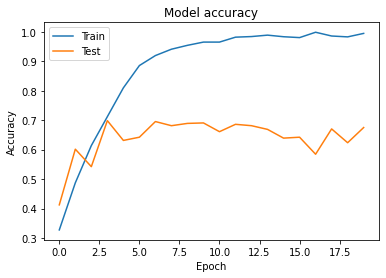

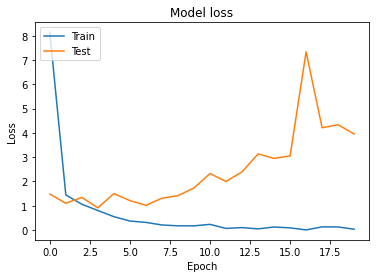

In [14]:
plot_learning_curves(history)

Au niveau de la précision, on remarque que l'apprentissage s'effectue bien avec 99 % de précision sur notre jeu d'apprentissage mais seulement 67% au niveau de notre jeu de test.

Cependant, au niveau de la perte, on remarque un cas de sur-apprentissage. En effet, si la perte au niveau du jeu d'entrainement diminue au fur et à mesure des épochs, la perte au niveau du jeu de test, elle, remonte, puis explose, à partir  de l'époch 5. 


On va par la suite, essayer d'améliorer ce modèle avec différentes méthodes.

- Génération de nos prédictions

In [15]:
pred_1=model.predict(valid_generator)

In [16]:
prediction1=np.zeros(pred_1.shape[0])
for i in range(pred_1.shape[0]):  
  probas = softmax(pred_1[i])
  prediction1[i]= np.argmax(probas)

## (3) Amélioration du modèle

### Data-augmentation

On va utilise une méthode de Data Augmentation qui consiste à étoffer notre échantillon d'apprentissage. En effet, pour chaque image présente dans notre échantillon d'apprentissage, on construit quatorzes nouvelles images qui ont subit des légères modifications. 

On ré-entraîne ensuite notre réseau de base avec ce nouvel échantillon d'apprentissage.

- Génération de nouvelles images pour l'échantillon d'apprentissage

In [17]:
augmenting_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40, # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2, # randomly shift images horizontally (fraction of total height)
    height_shift_range=0.2,# randomly shift images vertically (fraction of total height)
    shear_range=0.2,# set range for random shear
    zoom_range=0.2,# set range for random zoom
    horizontal_flip=True,# randomly flip images
    fill_mode='nearest' # set mode for filling points outside the input boundaries
)

- Affichage pour une image des quartorzes nouvelles images

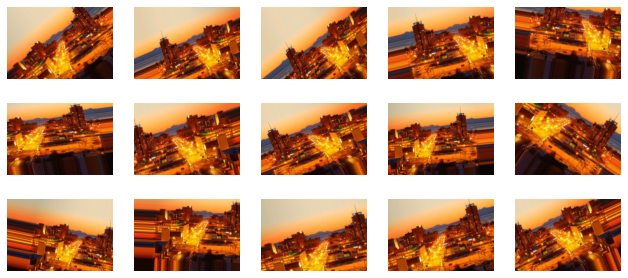

In [18]:
img = load_img(os.path.join(input_dir, 'city/3405806595_30426ee0dc.jpg'))
X =np.array(img)
plt.figure(figsize=(11, 5))
flow = augmenting_datagen.flow(X[np.newaxis, :, :, :])
for i, X_augmented in zip(range(15), flow):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_augmented[0])
    plt.axis('off')

- Entrainement du modèle avec le nouvel échantillon d'apprentissage

In [19]:
num_classes = 7

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',activation='relu', input_shape=(256, 256, 3)))
model2.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model2.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(7, activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

opt = RMSprop(lr=0.0001, decay=1e-6)
model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

train_generator2 = augmenting_datagen.flow_from_directory(
        input_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

history = model2.fit(
      train_generator2, ## Attention : on modifie ici l'échantillon d'apprentissage pour mettre le nouveau
      steps_per_epoch=64,
      epochs=20,
      validation_data=valid_generator,
      validation_steps=20)



Found 3781 images belonging to 7 classes.
Epoch 1/20
64/64 [==============================] - 36s 543ms/step - loss: 1.9113 - accuracy: 0.3657 - val_loss: 1.1827 - val_accuracy: 0.5578
Epoch 2/20
64/64 [==============================] - 35s 544ms/step - loss: 1.3334 - accuracy: 0.4918 - val_loss: 1.0405 - val_accuracy: 0.5797
Epoch 3/20
64/64 [==============================] - 35s 541ms/step - loss: 1.2237 - accuracy: 0.5347 - val_loss: 1.0740 - val_accuracy: 0.5891
Epoch 4/20
64/64 [==============================] - 35s 537ms/step - loss: 1.1565 - accuracy: 0.5703 - val_loss: 0.9868 - val_accuracy: 0.6500
Epoch 5/20
64/64 [==============================] - 34s 532ms/step - loss: 1.1450 - accuracy: 0.5735 - val_loss: 0.9222 - val_accuracy: 0.6359
Epoch 6/20
64/64 [==============================] - 34s 534ms/step - loss: 1.0717 - accuracy: 0.6016 - val_loss: 0.8948 - val_accuracy: 0.6797
Epoch 7/20
64/64 [==============================] - 43s 668ms/step - loss: 1.0636 - accuracy: 0.6081

- Affichage des courbes d'erreur après entrainement : 

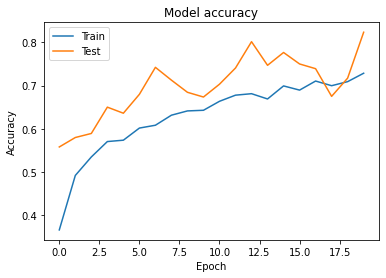

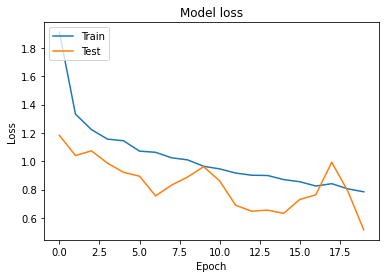

In [20]:
plot_learning_curves(history)

L'avantage de cette méthode est qu'elle permet de réduire significativement la perte sur l'échantillon de test. Cependant, elle est très longue. En effet, le temps pour effectuer 20 epochs a été considérablement augmenté.


De plus, pour le même nombre d'épochs que pour le modèle de base, nous n'atteignons pas le même pourcentage de précision, ce qui est logique considérant la nouvelle taille de notre échantillon d'apprentissage. 

- Génération de nos prédictions

In [21]:
pred_2=model2.predict(valid_generator)

In [22]:
prediction2=np.zeros(pred_2.shape[0])
for i in range(pred_2.shape[0]):  
  probas = softmax(pred_2[i])
  prediction2[i]= np.argmax(probas)

### Batch-Normalisation

On va rajouter une couche une couche de batch-normalisation entre les deux dernières de convolution du modèle de base pour améliorer les prédictions.

On pourrait en rajouter plus, mais l'important est ici de voir l'amélioration notable des prédictions seulement par l'ajout de cette couche.

- Entraînement du modèle

In [23]:
num_classes = 7
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), padding='same',activation='relu', input_shape=(256, 256,3)))
model3.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model3.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(7, activation='softmax'))
model3.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
history = model3.fit(
      train_generator,
      steps_per_epoch=64, 
      epochs=20,
      validation_data=valid_generator,
      validation_steps=20)


Epoch 1/20
64/64 [==============================] - 15s 213ms/step - loss: 1.4667 - accuracy: 0.4887 - val_loss: 8.8838 - val_accuracy: 0.1797
Epoch 2/20
64/64 [==============================] - 14s 211ms/step - loss: 1.1448 - accuracy: 0.5865 - val_loss: 3.8756 - val_accuracy: 0.3172
Epoch 3/20
64/64 [==============================] - 14s 213ms/step - loss: 0.9783 - accuracy: 0.6538 - val_loss: 4.7659 - val_accuracy: 0.3187
Epoch 4/20
64/64 [==============================] - 14s 214ms/step - loss: 0.7840 - accuracy: 0.7173 - val_loss: 3.5816 - val_accuracy: 0.2719
Epoch 5/20
64/64 [==============================] - 14s 213ms/step - loss: 0.5643 - accuracy: 0.8083 - val_loss: 95.8407 - val_accuracy: 0.0828
Epoch 6/20
64/64 [==============================] - 14s 214ms/step - loss: 0.4108 - accuracy: 0.8643 - val_loss: 1.2117 - val_accuracy: 0.6047
Epoch 7/20
64/64 [==============================] - 14s 214ms/step - loss: 0.2695 - accuracy: 0.9100 - val_loss: 1.8582 - val_accuracy: 0.592

- Affichage des courbes d'erreurs

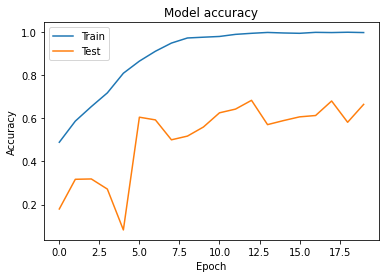

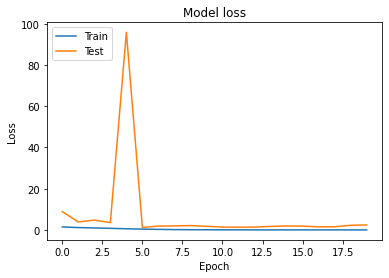

In [24]:
plot_learning_curves(history)

Ici, on ne remarque une amélioration dans l'explosion de l'erreur. En effet, celle-ci est plus contenue ce qui s'explique par l'ajout de cette couche qui va permettre d'éviter que le gradient explose lors de la rétro-propagation. L'ajout de ces couches permet donc d'améliorer l'apprentissage en évitant le sur-apprentissage mais elle ne permet pas d'améliorer la precision du réseau sur le jeu de test.

- Génération des prédictions 

In [25]:
pred_3=model3.predict(valid_generator)

In [26]:
prediction3=np.zeros(pred_3.shape[0])
for i in range(pred_3.shape[0]):  
  probas = softmax(pred_3[i])
  prediction3[i]= np.argmax(probas)

## (4) Réseau pré-entraîné

### Travail sur le réseau pré-entraîné

On va utiliser le modèle pré-entraîné VGG16, vu en TP. On l'importe donc  et on visualise les différentes couches à l'aide de <code> summary()</code>:

In [27]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

### Création et entraînement du nouveau modèle

- Entraînement du modèle

In [29]:
model4 = Sequential()
model4.add(conv_base)
model4.add(Flatten())
model4.add(Dense(256, activation='relu', name='features'))
model4.add(Dropout(0.2))
model4.add(BatchNormalization())
model4.add(Dense(7, activation='softmax'))
model4.compile(optimizer=RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 features (Dense)            (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 7)                 1799      
                                                      

On va geler la plupart des couches du réseau pré-entraîné et ne conserver que les dernières pour les ré-entraîner avec nos données.

On peut alors ensuite entraîner notre nouveau modèle.

In [30]:
## On gèle toutes les couches du réseau VGG16
conv_base.trainable = False

## On dégèle les dernières couches de convolutions 
for layer in conv_base.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3'] :
        layer.trainable = True


## On entraine le nouveau modèle
model4.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

history = model4.fit(
      train_generator,
      steps_per_epoch=64,
      epochs=20,
      validation_data=valid_generator,
      validation_steps=20)



Epoch 1/20
64/64 [==============================] - 23s 290ms/step - loss: 1.3796 - accuracy: 0.5039 - val_loss: 1.3027 - val_accuracy: 0.6187
Epoch 2/20
64/64 [==============================] - 20s 311ms/step - loss: 0.7203 - accuracy: 0.7620 - val_loss: 0.9415 - val_accuracy: 0.7859
Epoch 3/20
64/64 [==============================] - 18s 277ms/step - loss: 0.5508 - accuracy: 0.8235 - val_loss: 0.7274 - val_accuracy: 0.8359
Epoch 4/20
64/64 [==============================] - 18s 277ms/step - loss: 0.4378 - accuracy: 0.8648 - val_loss: 0.5965 - val_accuracy: 0.8531
Epoch 5/20
64/64 [==============================] - 18s 282ms/step - loss: 0.3889 - accuracy: 0.8857 - val_loss: 0.4714 - val_accuracy: 0.8875
Epoch 6/20
64/64 [==============================] - 18s 280ms/step - loss: 0.3169 - accuracy: 0.9087 - val_loss: 0.4348 - val_accuracy: 0.8734
Epoch 7/20
64/64 [==============================] - 18s 278ms/step - loss: 0.2771 - accuracy: 0.9253 - val_loss: 0.3983 - val_accuracy: 0.8813

- Affichage des courbes d'erreur et de précision

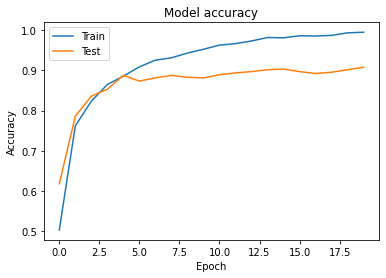

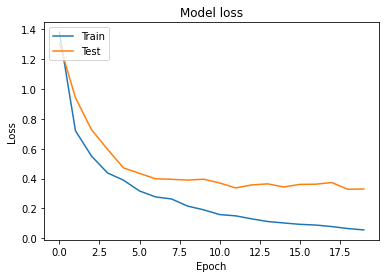

In [31]:
plot_learning_curves(history)

On obtient ici des résultats bien plus satisfaisants qu'avec les autres modèles. En effet, les deux courbes de précisions sont à plus de 89% tandis que les deux courbes d'erreurs sont faibles et n'explosent pas. Plus d'épochs permettraient d'améliorer encore la précision. 

- Génération de nos prédictions

In [32]:
pred4=model4.predict(valid_generator)

In [33]:
prediction4=np.zeros(pred4.shape[0])
for i in range(pred4.shape[0]):  
  probas = softmax(pred4[i])
  prediction4[i]= np.argmax(probas)

## (5) Récapitulatif des résultats obtenus

Tous les résulats obtenus avec les quatre modèles sont récapitulés dans le tableau ci-dessous. Il faut noter que chaque modèle a été entrainé avec le même nombre d'epochs ($20$) et que l'on affiche les résultats après la dernière époch. En effet, le calcul d'un <code> accuracy_score</code> n'est pas possible avec les générateur étant donné que ces derniers ne permettent pas de récupérer le label exact.

|Méthode     | Apprentissage |Précision apprentissage  |Précision test |Erreur apprentissage| Erreur test | 
| ----------- | ----------- |----------- | ----------- |----------- | ----------- |
| Réseau de base     | Rapide : 6min     |  $99.46\%$    | $67.50\%$      |$0.0318$      | $3.9547$       |
| Réseau de base + Data Augmentation   | Plus long : 12 min      |$72.85\%$    | $82.34\%$      | $0.7845$      | $0.5154$      |
| Réseau de base + Batch Normalisation    | Rapide : 5 min     | $99.66\%$    | $66.41\%$       |$0.0131$      | $2.4276$      |
| Réseau pré-entrainé  | Rapide : 6 min      |$99.46\%$      | $90.78\%$      |$0.0560$      | $0.3303$       | 





* **Modèle 1** - Base : Le modèle fait du sur-apprentissage et l'ajout d'épochs n'améliorerait pas les prédictions.

* **Modèle 2** - Base + Data Augmentation : Ce modèle est long à faire tourner et nécessiterait bien plus d'épochs pour être vraiment efficace. En effet, la taille de l'échantillon d'apprentissage est considérablement augmenté et son apprentissage est donc beaucoup plus long. Cependant, pour seulement 20 épochs, on remarque que la perte sur le jeu de test est déjà faible comparé au modèle de base. C'est donc une bonne amélioration.

* **Modèle 3** - Base + Batch Normalisation : Le but ici était de pouvoir contenir l'explosion sur la perte sur le jeu de test, ce qui est le cas ici. On ne gagne pas en précision mais on fait moins de sur-apprentissage.

* **Modèle 4** - Réseau pré-entrainé : Pour le même nombre d'épochs que les autres, ce modèle semble être un bon compromis. Il nécessiterait, lui aussi, un entrainement avec plus d'épochs pour améliorer les performances. On note aussi que pour ce modèle, en plus du modèle pré-entrainé, on a ajouté des couches et notamment une couche de batch normalisation qui a permi de faire baisser la perte sur le jeu de test.

Nous avons donc vu ici différents modèles avec différentes piste d'améliorations. Compte tenu des limitations du GPU de google colab, nous nous limiterons à ces 20 épochs. Nous savons, cependant, que le modèle 4 avec les améliorations du modèle 2 et 3 pourrait être mis en oeuvre afin d'obtenir un modèle encore plus précis avec peu de perte.



## (6) Affichage des prédictions

### Fonction pour afficher nos predictions

In [34]:
def plot_prediction(model_u,ligne,col, bon =1 ):
  k=0
  plt.figure(figsize=(11,11))
  for i in range(755):
    if k<col*ligne:
      if i%32==0:
        y_2 = next(valid_generator)
      pred_current=model_u.predict(y_2[0])
      y_pred=np.argmax(pred_current[i])
      y_true=np.argmax(y_2[1][i])
      if bon==1:
        if y_pred==y_true:
          k+=1
          plt.subplot(ligne,col,k)

          plt.title('True = %s, predicted=%s'%(liste_classes[y_true],liste_classes[y_pred]))
          plt.imshow(y_2[0][i])
      else:
        if y_pred!=y_true:
          k+=1
          plt.subplot(ligne,col,k)

          plt.title('True = %s, predicted=%s'%(liste_classes[y_true],liste_classes[y_pred]))
          plt.imshow(y_2[0][i])



On va tester notre fonction en affichant : 
- des bonnes prédictions ;
- des mauvaises prédictions.

- **Modèle 1 : bonnes prédictions**

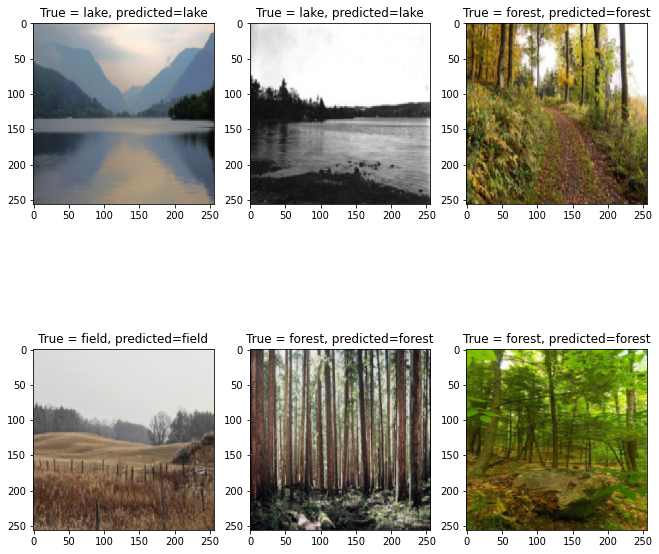

In [35]:
plot_prediction(model,2,3, bon =1 )

- **Modèle 1: Mauvaises prédictions**

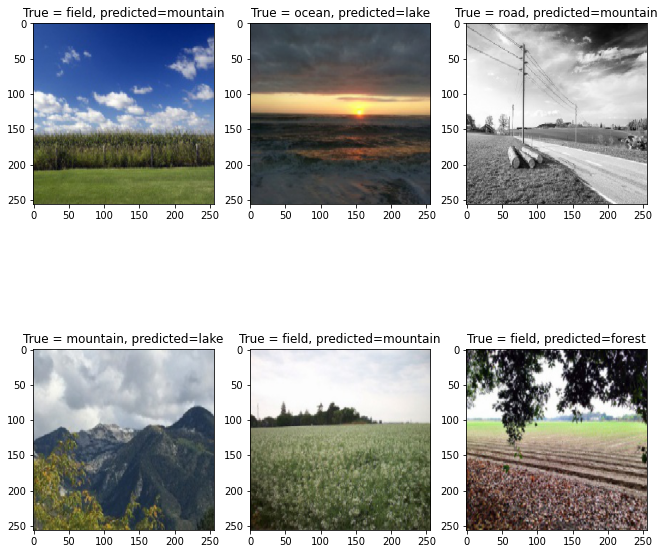

In [36]:
plot_prediction(model,2,3, bon =0 )

### Affichage de quelques exemples sur lesquels les réseaux se trompent

- Modèle 1 : modèle de base

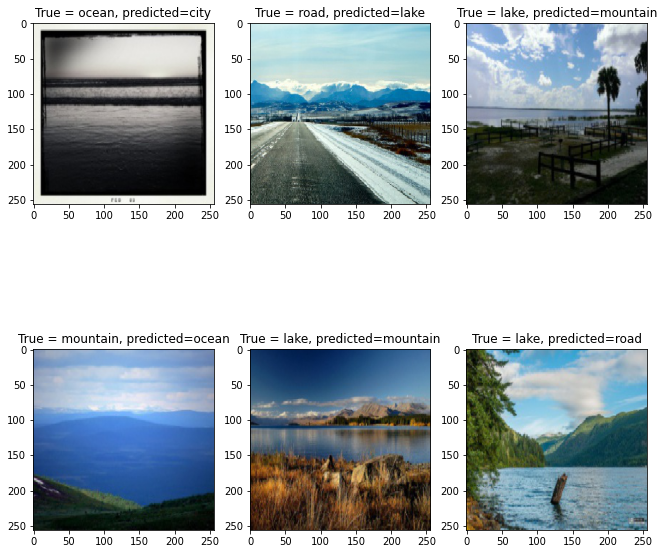

In [37]:
plot_prediction(model,2,3, bon =0 )

- Modèle 2 : modèle de base avec Data Augmentation

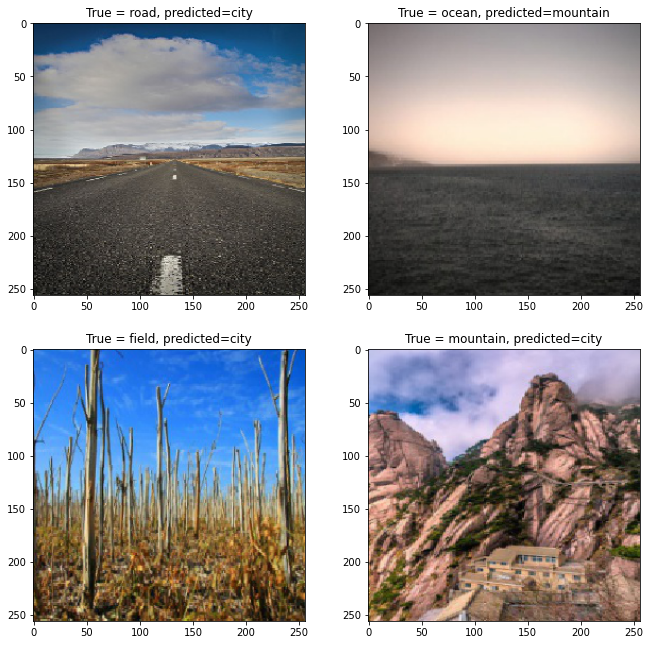

In [39]:
plot_prediction(model2,2,2, bon =0 )

- Modèle 3 : modèle de base avec Batch Normalisation

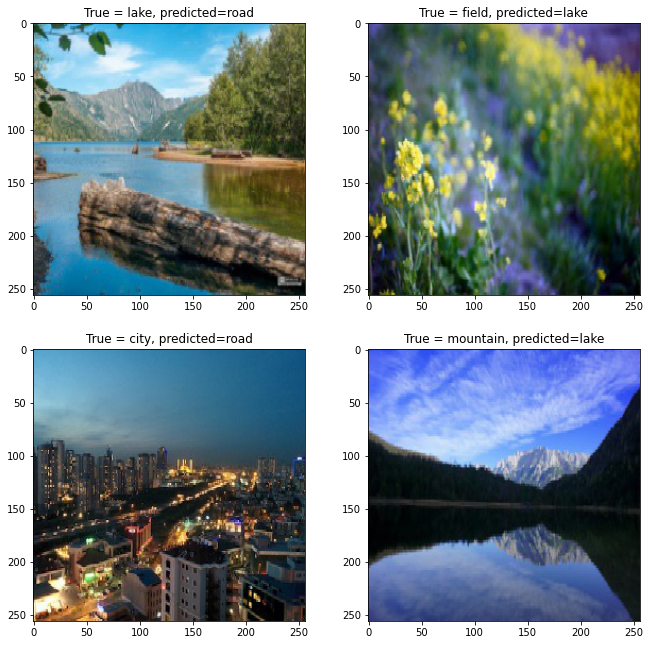

In [40]:
plot_prediction(model3,2,2, bon =0 )

- Modèle 4 : modèle pré-entrainé

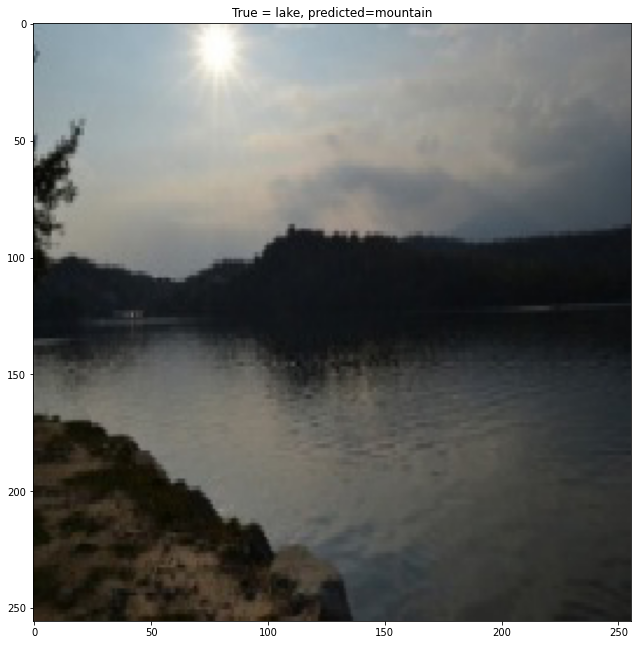

In [43]:
plot_prediction(model4,1,1, bon =0 )

## (7) T-SNE sur les features

On cherche à visualiser nos projections dans l’espace des features à l’aide d’une t-SNE sur un sous ensemble du dataset (quelques centaines d’images). On va récupérer les features à l'aide de la fonction extract_features utilisée en TP. On va ensuite reshape les features récupérées et on pourra ensuite appliquer la TSNE.


In [44]:
import seaborn as sns

- Récupération des features et labels prédits par le réseau

In [167]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 32


def extract_features(directory, sample_count,shuffle_mode=True):
    features = np.zeros(shape=(sample_count, 8, 8, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(256, 256),
        batch_size=batch_size,
        shuffle=shuffle_mode,
        class_mode='sparse' )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels,generator
features, labels,generator = extract_features(input_dir, 3776)

Found 3781 images belonging to 7 classes.


In [168]:
train_features=features[0:3020]
test_features=features[3020:3776]
train_labels=labels[0:3020]
test_labels=labels[3020:3776]

- Calcul de la TSNE

In [169]:
train_features = np.reshape(train_features, (3020, 8 * 8 * 512))
test_features = np.reshape(test_features, (756, 8 * 8 * 512))
features = np.reshape(features, (3776, 8 * 8 * 512))

On applique la TSNE aux features.

In [170]:
X_tsne=TSNE().fit_transform(features)

On peut alors afficher nos projections dans l'espace des features  en ne gardant que quelques centaines d'éléments.

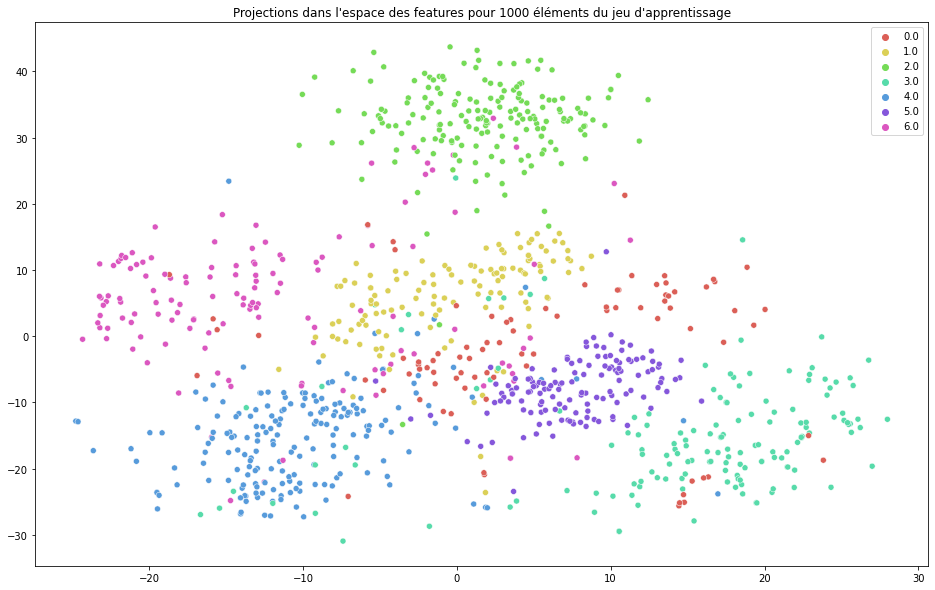

In [171]:
plt.figure(figsize=(16,10))
plt.title("Projections dans l'espace des features pour 1000 éléments du jeu d'apprentissage")
sns.scatterplot(x=X_tsne[0:1000,0], y=X_tsne[0:1000,1],hue=labels[0:1000],palette=sns.color_palette("hls", 7),legend="full")

## (8) Méthode des plus proches voisins

On veut appliquer la méthodes des plus proches voisins sur nos features récupérées à la question (7). On va utiliser la méthode sur tout notre échantillon car le but ici est de trouver les trois plus proches voisins. Vu que l'on va appliquer le classifieur au même échantillon que celui que l'on utilise pour fit, on met un nombre de voisin égal à 4. En effet, le voisin le plus proche sera toujours l'image elle-même. De plus, en utilisant deux fois le même échantillon, on élimine le problème de sur-apprentissage.

In [172]:
from sklearn.neighbors import KNeighborsClassifier

In [173]:
classifier=KNeighborsClassifier(n_neighbors=4,weights='distance',algorithm='auto',p=2)

In [174]:
classifier.fit(X_tsne, labels)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [175]:
pred_voisin=classifier.kneighbors(X=X_tsne, n_neighbors=4, return_distance=True)

On calcule le score pour vérifier que le classifieur fonctionne bien.

In [176]:
classifier.score(X_tsne,labels)

1.0

On va choisir une image au hasard dans notre jeu de test et voir la prédiction des voisins que l'on obtient.

On va donc parcourir le générateur pour afficher ces images voisines.


In [210]:
from numpy.random.mtrand import noncentral_chisquare
def plot_voisins(liste_voisins,gen):
  # On choisit une image au hasard :
  Id=np.random.randint(0,len(features))

  #On récupère les trois plus proches voisins pour cet indice : 
  voisins=np.sort(liste_voisins[1][Id][1:4])

  #On va pouvoir ouvrir les images
  ## Ouverture et affichage de l'image tirée aléatoirement : 
  plt.figure(figsize=(8,8))
  plt.title("Image tirée aléatoirement") 
  cpt=0
  while cpt<=Id:
      if cpt%32==0:
        y=next(gen)
      for j in range(32):
        if cpt== Id :
          img=(y[0][j]-(y[0][j].min()))/(y[0][j].max()-y[0][j].min())
          plt.imshow(img)
          plt.show()
        cpt+=1 

  
  ## Ouverture et affichage des images voisines
  plt.figure(figsize=(10,10))
  cpt=0
  for i in range(3):
    current_voisin=voisins[i]
    while cpt<=current_voisin:
      if cpt%32==0:
        y=next(gen)
      for j in range(32):
        if cpt== current_voisin :
          plt.subplot(1,3,i+1)
          plt.title('Distance = %f'%(liste_voisins[0][Id][i+1]))
          img=(y[0][j]-(y[0][j].min()))/(y[0][j].max()-y[0][j].min())
          plt.imshow(img)
          
        cpt+=1
  plt.show()
  return(None)


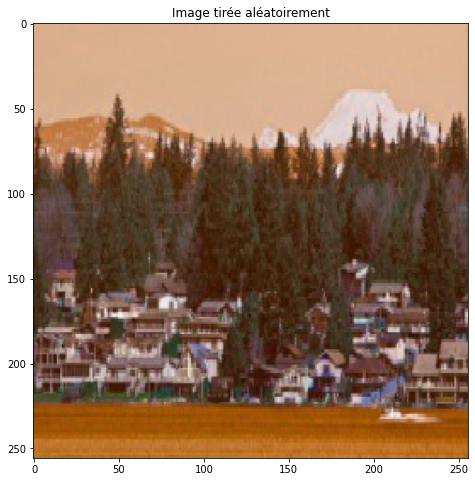

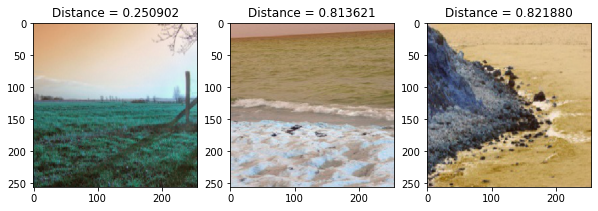

In [211]:
plot_voisins(pred_voisin,generator)

On peut exécuter la celle ci-dessus plusieurs fois pour voir différents résultats. 

L'affichage des images correspondantes est assez difficile car nous utilisons les images du générateur avec un pré-processing particulier. En effet, les intensités ne sont plus très bien respectées ici. Cependant, les résultats semblent assez cohérents.